In [1]:
import math
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

## Constants

In [2]:
# constants in SI
m = 9.10938291E-31 # mass of electron
q = 1.60217657E-19 # charge of electron
ε = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # plancks magical number
hbar = 1.054571800E-34 # reduced planck
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
# units
Å = 1E-10 # m to angstrom
k = 1.38064852E-23

## Functions and checks against literature

For polaron theory see:

- http://sjbyrnes.com/FinalPaper--Polarons.pdf (Introduction)
- https://arxiv.org/pdf/cond-mat/0004497.pdf (Devreese review)

In [10]:
def exciton_binding_energy(ε_inf, mu):
    # mu is reduced mass (me*mh/(me+mh))
    # definition from doi:10.1103/PhysRev.116.573
    epsilon = ε_inf*ε*4*math.pi
    energy = ((q**4)*mu*m) / (2*(hbar**2)*(epsilon**2))
    return 1000*energy/q # meV

# Comparison with existing data for CdS doi:10.1103/PhysRev.116.573
print (exciton_binding_energy(9.3, 0.18)) # value in literature 28meV

28.315693534743613


In [11]:
def frolich_alpha(ε_inf,ε_0, ω_char, m_e):
    # definition from book "Polarons" David Emin - originally Frolich 1963 
    # within this definition is assumption polaron is large (LO/Frolich interaction)
    epsilon_inf = ε_inf*ε*4*math.pi
    epsilon_0 = ε_0*ε*4*math.pi
    α=((q**2)/hbar)*((1/epsilon_inf) - (1/epsilon_0))*(((m_e*m)/(2*hbar*ω_char))**0.5)
    return α # dimensionless

# Comparison with existing data for NaCl doi:10.1103/PhysRev.97.660
print (frolich_alpha(2.3, 5.6, 4.9E13, 1.0)) # value in literature ~5 

5.262322325147562


In [12]:
def polaron_mass(alpha,m_e):
    # weak coupling definition from doi:10.1103/PhysRev.116.573 - originally Feynmann
    # Both masses are an approximation
    weak_coupling_mass = m_e*(1+(alpha/6))
    strong_coupling_mass = m_e*(0.02*(alpha**4)) 
    return weak_coupling_mass, strong_coupling_mass # in units of electron bare mass

In [6]:
def polaron_radius(ε_inf,ε_0, ω_char, m_e):
    epsilon_inf = ε_inf*ε*4*math.pi
    epsilon_0 = ε_0*ε*4*math.pi
    # definitions from Devreese review
    weak_coupling_radius = math.sqrt(hbar/(2*m*m_e*ω_char))
    strong_coupling_radius = ((hbar**2)/(m*m_e*(q**2)))*(1/((1/epsilon_inf)-(1/epsilon_0)))
    return weak_coupling_radius, strong_coupling_radius # in m

# polaron radius for NaCl in strong coupling limit 
print (polaron_radius(2.3, 5.6, 4.9E13, 1.0)[1]/(0.56E-9)) # in unit cells of NaCl

0.368820529797238


In [32]:
def polaron_temperature(radius,energy,heat_capacity,lattice_constant):
    volume_polaron = (4/3)*math.pi*(radius**3)
    volume_one_mole = avogadro*((lattice_constant)**3) 
    moles = volume_polaron / volume_one_mole
    temperature = energy / (heat_capacity*moles)
    return temperature # in K measured above bulk temperature

def polaron_energy(radius,temperature,heat_capacity,lattice_constant):
    volume_polaron = (4/3)*math.pi*(radius**3)
    volume_one_mole = avogadro*((lattice_constant)**3) 
    moles = volume_polaron / volume_one_mole
    energy = temperature*heat_capacity*moles
    return energy

In [33]:
def polaron_density(radius):
    # very simpe - boxes (2r)^3 stacked together
    volume = ((2*radius)**3)*(10**6) 
    return (1/volume) # in /cm^3

In [34]:
def mott_criterion(static_perm=False,eff_mass=False,radius=False,c=0.25):
    # definition from doi:10.1103/PhysRevB.17.2575
    if radius:
        # note similarity with polaron_density definition (factor of 8 difference)
        density = (c/radius)**3 
    elif static_perm and eff_mass:
        density = ((c*eff_mass*q*q)/(static_perm*hbar*hbar))**3
    return density/(10**6) # in /cm^3

In [35]:
def diffusivity(thermal_conductivity, d, molecular_weight):
    # diffusivity = thermal_conductivity / (density*heat capacity)
    density = (molecular_weight/avogadro) / (d**3) # g/m^3 
    heat_cap = heat_capacity / molecular_weight # J/g/K
    return thermal_conductivity / (density*heat_cap) # m^2/s

## Values for MAPI

In [36]:
# effective mass electron listed below, for hole use the value 0.15
# from QSGW calculation, doi:10.1021/nl500390f
m_e = 0.12
m_red = (0.12*0.15)/(0.12+0.15)

# lattice constant from neutron diffraction, doi:10.1038/srep35685
d = 6.306*Å

# from IR spectroscopy, doi:10.1016/0022-3697(90)90021-7
heat_capacity =  180 # J/mol/K

# using http://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm
molecular_weight = 619.98 # g/mole

# bandgap from experimental (300 K), doi:10.7567/APEX.7.032302
# (bandgap from QSGW calculation is 1.67, doi:10.1103/PhysRevB.89.155204)
ε_g = 1.61

# static dielectric from DFT+QSGW, doi:10.1063/1.4824147
ε_0 = 24.5  

 # optical dielectric from QSGW, doi:10.1063/1.4824147
ε_inf = 4.5

# characteristic phonon frequency from analysis of DFT phonons (Jarv's mobility paper)
ω_char = 2.25E12*2*math.pi

In [37]:
# First calculate the binding energy of an exciton in MAPI
exciton_binding_energy(ε_inf, m_red)

44.792397509281656

In [38]:
 
# 25.7 meV is kT at 300K
# Excitons dissasocciate into free particles. 
# ---> We do not need to consider polaronic excitons.

# Now calculate the frolich coupling constant alpha. 
# This depends upon the static dielectric, optical dielectric 
# and characteristic phonon frequency for which there are several values
frolich_alpha(ε_inf,ε_0, ω_char, m_e)

2.402914046984631

In [39]:
# if alpha is << 1 then we have weak coupling limit
# if alpha >> 5 we have the strong coupling limit
# MAPI is an intermediate case, as has been found previously for perovskites

# Now calculate the polaron radius
# theory is different depending upon whether we consider weak or string coupling.
# We will calculate for both
weak_radius = polaron_radius(ε_inf,ε_0, ω_char, m_e)[0]
strong_radius = polaron_radius(ε_inf,ε_0, ω_char, m_e)[1]
print (weak_radius, strong_radius)

5.8412633132913535e-09 2.4309081386500018e-09


In [40]:
# Sideline: Now let's calculate the density of polarons at which they'd start "touching" and the mott criterion
for x in [weak_radius,strong_radius]:
    print ("radius: ",str(x)+", polaron density: "+str(polaron_density(x))+", mott density: "+str(mott_criterion(radius=x))+'\n')

radius:  5.8412633132913535e-09, polaron density: 6.271763328052504e+17, mott density: 7.83970416006563e+16

radius:  2.4309081386500018e-09, polaron density: 8.701705281883547e+18, mott density: 1.0877131602354433e+18



In [41]:
# Sideline ctd: it's the density at which we move from the region of
# large polaron formation to phonon bottleneck region: see dx.doi.org/10.1126/science.aaf9570

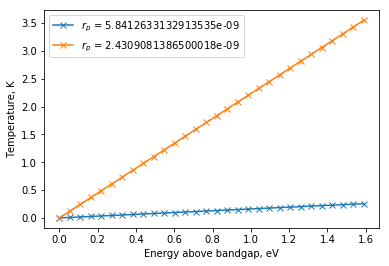

In [42]:
# The polaron radius is on the order 10's of angstroms for whichever case is used.
# We now have all the information needed to calculate the temperature 
# when the electrons' excess energy is distributed to form a polaron

# energy range considering Air Mass 1.5 spectrum, http://rredc.nrel.gov/solar/spectra/am1.5/
# and the window of a TCO (absorbed above 3.2eV)
photon_energies = np.linspace(ε_g,3.2,30)
excitation_ke = [(x - ε_g)*q for x in photon_energies] # assume all KE to conduction band electron
           
for radius in [weak_radius,strong_radius]:
    temperature = []
    for energy in excitation_ke:
        temperature.append(polaron_temperature(radius,energy,heat_capacity,d))
    plt.plot([x/q for x in excitation_ke],temperature,label="$r_p$ = "+str(radius),marker='x')
    plt.xlabel("Energy above bandgap, eV")
    plt.ylabel("Temperature, K")
    plt.legend()
           

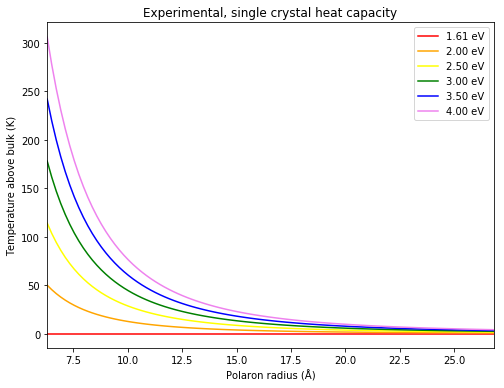

In [44]:
## heat capacity from experimental work

photon_energies = [(x - ε_g)*q for x in [1.61,2,2.5,3,3.5,4]]
colours = ['red','orange','yellow','green','blue','violet']
counter = 0

heat_capacity =  180 # J/mol/K

fig = plt.figure(figsize=(8,6))
for energy in photon_energies :
    temperature = []
    for radius in np.linspace(d,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy,heat_capacity,d))
    plt.plot((np.linspace(d,26.8*Å,100))/Å,temperature,label="{:.2f}".format((energy/q)+ε_g)+" eV",color = colours[counter])
    counter += 1
    plt.title("Experimental, single crystal heat capacity")
    plt.xlabel("Polaron radius (Å)")
    plt.xlim([6.306,26.8])
    plt.ylabel("Temperature above bulk (K)")
    plt.legend()
    plt.savefig("T_radius_exp.pdf")

In [45]:
## heat capacity from density of states

heat_capacity = 1.25 # meV/unit cell/K
heat_capacity = (1.25/1000)*q # J/unit cell/K
heat_capacity = heat_capacity*avogadro # J/mol/K
print (heat_capacity)

120.60668096444826


<Figure size 720x720 with 0 Axes>

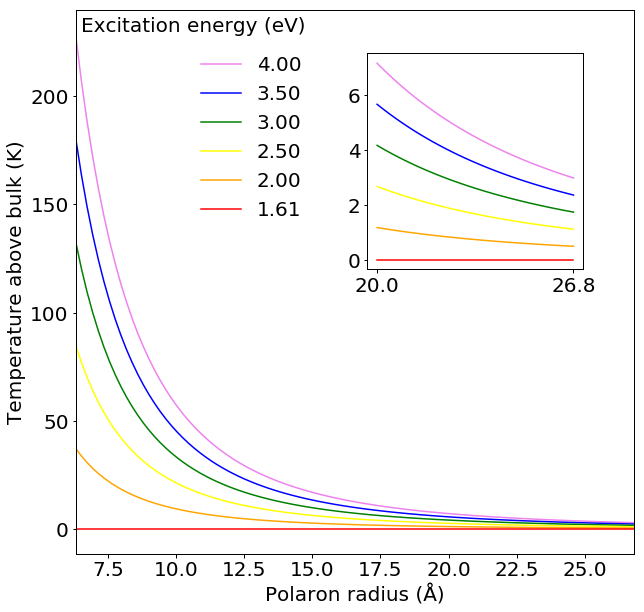

In [46]:
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['axes.linewidth'] = 1 
mpl.rcParams['xtick.major.width'] = 1 
mpl.rcParams['ytick.major.width'] = 1 
fig = plt.figure(figsize=(10,10))

photon_energies = [(x - ε_g)*q for x in [1.61,2,2.5,3,3.5,4]]
colours = ['violet','blue','green','yellow','orange','red']
counter = 0

heat_capacity = 1.25 # value given in text, meV/unit cell/K
heat_capacity = (1.25/1000)*q # J/unit cell/K
heat_capacity = heat_capacity*avogadro # J/mol/K


fig = plt.figure(figsize=(10,10))
for energy in reversed(photon_energies) :
    temperature = []
    for radius in np.linspace(d,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d)) # divide by two as half goes to electron
    plt.plot((np.linspace(d,26.8*Å,100))/Å,temperature,label="{:.2f}".format((energy/q)+ε_g),color = colours[counter])
    counter += 1
#    plt.title("Heat capacity from phonon density of states")
plt.xlabel("Polaron radius (Å)")
plt.xlim([6.306,26.8])
#plt.ylim([-1,250])
plt.ylabel("Temperature above bulk (K)")
plt.legend(loc=(0.21,0.60),frameon=False)
plt.text(6.5,230,"Excitation energy (eV)")

counter = 0    
a = plt.axes(([.53, .52, .3, .3]))
for energy in reversed(photon_energies) :
    temperature = []
    for radius in np.linspace(20*Å,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy/2,heat_capacity,d))
    plt.plot((np.linspace(20*Å,26.8*Å,100))/Å,temperature,color = colours[counter])
    counter += 1
plt.xticks([20,26.8]) 
plt.yticks()

plt.savefig("T_radius_inset.png")


#polaron_temperature(26.8*Å,2.39*q,120,d)


In [47]:
## heat capacity from dulong-petit

heat_capacity= 3*k*avogadro*12
print (heat_capacity)

299.3206013853714


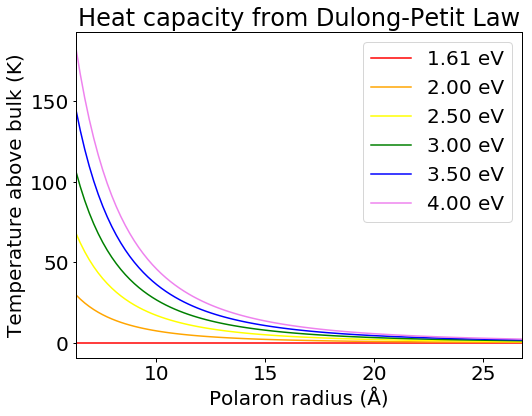

In [48]:
## heat capacity from dulong-petit

heat_capacity= 3*k*avogadro*12

photon_energies = [(x - ε_g)*q for x in [1.61,2,2.5,3,3.5,4]]
colours = ['red','orange','yellow','green','blue','violet']
counter = 0

fig = plt.figure(figsize=(8,6))
for energy in photon_energies :
    temperature = []
    for radius in np.linspace(d,26.8*Å,100):
        temperature.append(polaron_temperature(radius,energy,heat_capacity,d))
    plt.plot((np.linspace(d,26.8*Å,100))/Å,temperature,label="{:.2f}".format((energy/q)+ε_g)+" eV",color = colours[counter])
    counter += 1
    plt.title("Heat capacity from Dulong-Petit Law")
    plt.xlabel("Polaron radius (Å)")
    plt.xlim([6.306,26.8])
    plt.ylabel("Temperature above bulk (K)")
    plt.legend()
    plt.savefig("T_radius_dulong-petit.pdf")

In [82]:
# We can now use calculated temperature to model heat diffusion 
# Functions are available in heatdiffusion.ipynb so run this to gain access

%run heat_diffusion.ipynb

# heat capacity from density of states
heat_capacity = 120

# currently set so thermal conductivity out of plane is lower
# from calculations, doi:10.1039/c6cp04246e
thermal_conductivity_x = 0.3 # W.m-1.k-1 
thermal_conductivity_y = 0.3 # W.m-1.k-1 
thermal_conductivity_z = 0.1 # W.m-1.k-1 
Dx = diffusivity(thermal_conductivity_x,d,molecular_weight,heat_capacity)
Dy = diffusivity(thermal_conductivity_y,d,molecular_weight,heat_capacity)
Dz = diffusivity(thermal_conductivity_z,d,molecular_weight,heat_capacity)




T = 10
r = 2.4e-9

# parameters for finite difference method
# These parameters fix the size of the grid. 
# For example, the total $x$ length of the plate will be $\delta x\times nx$.
dt=1E-13
dx=10*Å 
dy=10*Å
dz=10*Å
nx=40
ny=40
nz=40
nt=2000

# it is important that the dimensionless parameter F is < 0.5 for the solution to be stable
assess_stability(max([Dx,Dy,Dz]),dx,dt)

F is 0.03775312313669496


In [78]:
# set up initial temperature distribution the size of polaron radius
p = initial_conditions(r, T, dx, dy, dz, dt, nx, ny, nz, nt)
print(p[20,20,20,0])


initial hot cells:57
10.0


(0.0, 40.0, 0.0, 40.0)

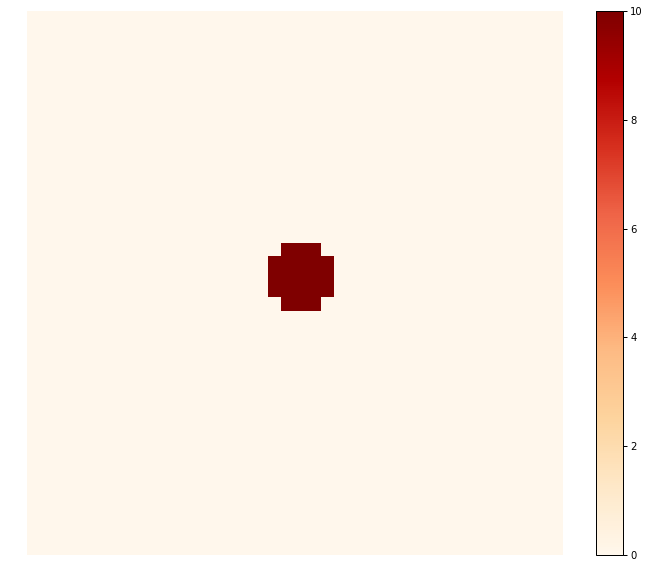

In [79]:
fig = plt.figure(figsize=(12,10))
plt.pcolormesh(p[:,:,20,0],cmap='OrRd') # take a slice through (visualising xy plane)
plt.colorbar()
plt.axis('off')

In [81]:
# now iterate through time
p = step_through(p, Dx, Dy, Dz, dx, dy, dz, dt, nx, ny, nz, nt)

100%|██████████| 1999/1999 [00:33<00:00, 59.42it/s]


In [83]:
print(p.min())
print(p.max())

0.0
10.0


In [85]:
# this can take some time - option to save the output
# pickle.dump(p,open("MAPI_polaron_cooling.p","wb"))
# to load use "pickle.load(open("MAPI_polaron_cooling.p", "rb"))


(0, 2100)

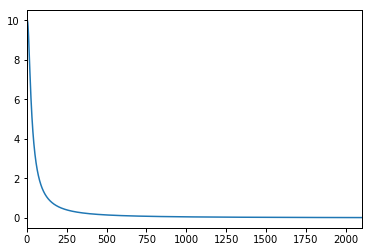

In [73]:
# inspect temperature through time at centre to check "sensible" behaviour
plt.plot(p[20,20,20,:])
plt.xlim([0,2100])

(0, 2100)

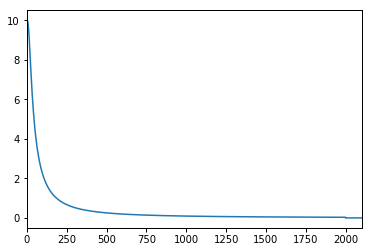

In [86]:
# inspect temperature through time at centre to check "sensible" behaviour
plt.plot(p[20,20,20,:])
plt.xlim([0,2100])

(0.0, 40.0, 0.0, 40.0)

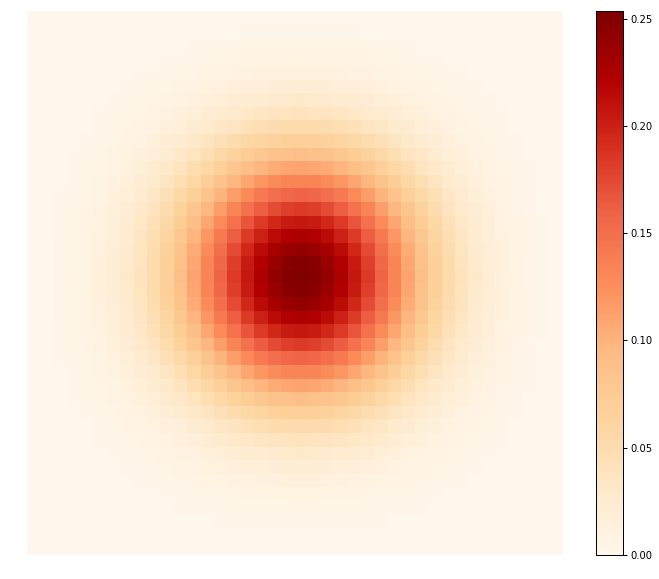

In [88]:
# visualise heat as slice through the centre (xy plane) at a given time
fig = plt.figure(figsize=(12,10))
plt.pcolormesh(p[:,:,20,500],cmap='OrRd')
plt.colorbar()
plt.axis('off')


(0.0, 40.0, 0.0, 40.0)

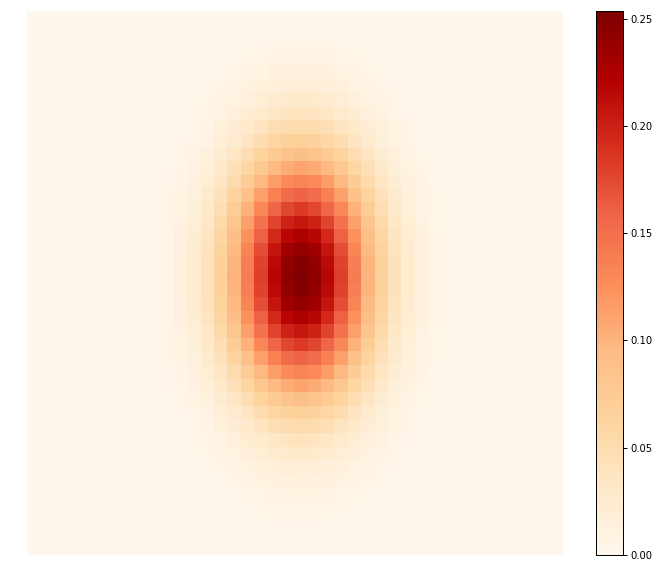

In [90]:
# visualise heat as slice through the centre (zx plane) at a given time
fig = plt.figure(figsize=(12,10))
plt.pcolormesh(p[20,:,:,500],cmap='OrRd')
plt.colorbar()
plt.axis('off')

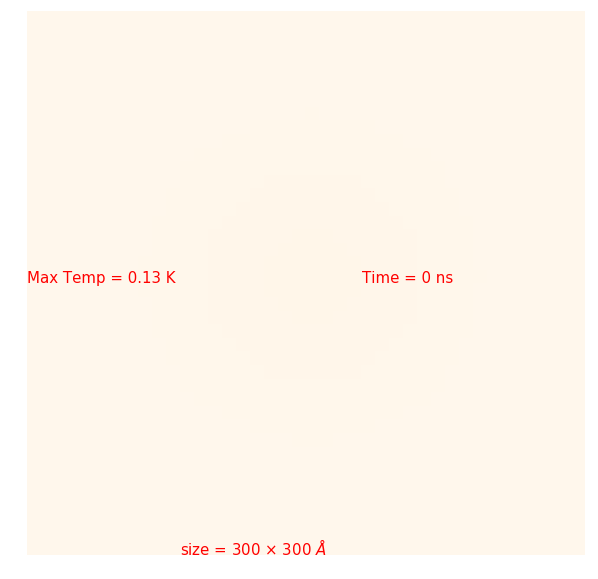

In [91]:
# animate the heat flow through time

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mesh = ax.pcolormesh(p[:,:,20,0])
txt = ax.text(0,20,'',fontsize=15,color='red')
txt2 = ax.text(24,20,'',fontsize=15,color='red')
txt3 = ax.text(11,0,r'size = 300 $\times$ 300 $\AA$',fontsize=15,color='red')
plt.axis('off')


def init():
    mesh.set_cmap('OrRd')
    mesh.set_clim(vmin=p.min(),vmax=p.max())

    return mesh,txt,txt2
 
def animate(i):
    data = p[:,:,20,i]
    mesh.set_array(data.ravel())
    mesh.autoscale()
    txt.set_text("Max Temp = %.2f K"%p[:,:,:,i].max())
    txt2.set_text("Time = %.0f ns"%((dt/10E-9)*i))

    return mesh,txt,txt2

anim = animation.FuncAnimation(fig, animate, interval = 10,frames = 800, init_func=init)
HTML(anim.to_html5_video())
anim.save('heatflow2.mp4', fps=30)



In [92]:
# This shows that the heat has distributed (to within 12kT) in 80*1e-10 seconds (65 ns) across a volume of (600A)**3.
# We should check that a similar result is found with respect to:
            # time step size
            # space step size
            # number of steps in space. 

# can inspect the boundaries (or nearest neighbour to boundary) to ensure that the fixed temperature boundary conditions are reasonable